In [76]:
from __future__ import absolute_import, division, print_function

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, GRU, LSTM
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D


In [11]:
train = pd.read_csv('drugsComTrain_raw.csv')
test = pd.read_csv('drugsComTest_raw.csv')

train.head(5)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
# Create labels based on the original article: Grässer et al. (2018)
r = data['rating']
labels = -1*(r <= 4) + 1*(r >= 7)
# Add the label column to the data
data['label'] = labels
# Check the new data
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,1


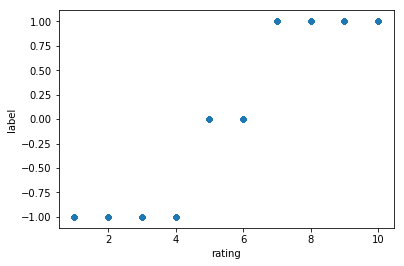

In [6]:

data.plot(x = 'rating', y = 'label', kind = 'scatter')
plt.show()

In [60]:
# Read a part of the reviews and create training sequences (x_train)
samples = data['review'].iloc[:50000]
tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
x_train = pad_sequences(sequences, maxlen = 500)

In [64]:
# Convert the labels to one_hot_category values
one_hot_labels = to_categorical(labels[:50000], num_classes = 3)

In [27]:
# We use the same plotting commands several times, so create a function for that purpose
def plot_history(history):
    
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# First test model

In [47]:
# First model: Embedding layer -> Flatten -> Dense classifier
m0 = Sequential()
m0.add(Embedding(1000, 64, input_length = 500)) # 1000 = num_words, 64 = Embedding layers, 500 = sequence length
m0.add(Flatten())
m0.add(Dense(32, activation = 'relu'))
m0.add(Dense(3, activation = 'softmax'))
m0.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 64)           64000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1024032   
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 99        
Total params: 1,088,131
Trainable params: 1,088,131
Non-trainable params: 0
_________________________________________________________________


In [48]:
h0 = m0.fit(x_train, one_hot_labels, epochs = 10, batch_size = 32, verbose = 1, validation_split = 0.25)

Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 6s 849us/step - loss: 0.8394 - acc: 0.6577 - val_loss: 0.7804 - val_acc: 0.6564
Epoch 2/10
7500/7500 [==============================] - 6s 778us/step - loss: 0.6494 - acc: 0.7447 - val_loss: 0.6796 - val_acc: 0.7296
Epoch 3/10
7500/7500 [==============================] - 6s 744us/step - loss: 0.4956 - acc: 0.8099 - val_loss: 0.7661 - val_acc: 0.6792
Epoch 4/10
7500/7500 [==============================] - 6s 756us/step - loss: 0.3394 - acc: 0.8772 - val_loss: 0.8680 - val_acc: 0.7200
Epoch 5/10
7500/7500 [==============================] - 6s 784us/step - loss: 0.1945 - acc: 0.9405 - val_loss: 0.8714 - val_acc: 0.7044
Epoch 6/10
7500/7500 [==============================] - 6s 755us/step - loss: 0.1014 - acc: 0.9707 - val_loss: 1.1260 - val_acc: 0.7128
Epoch 7/10
7500/7500 [==============================] - 6s 759us/step - loss: 0.0505 - acc: 0.9865 - val_loss: 1.3231 - val_acc: 0.7036


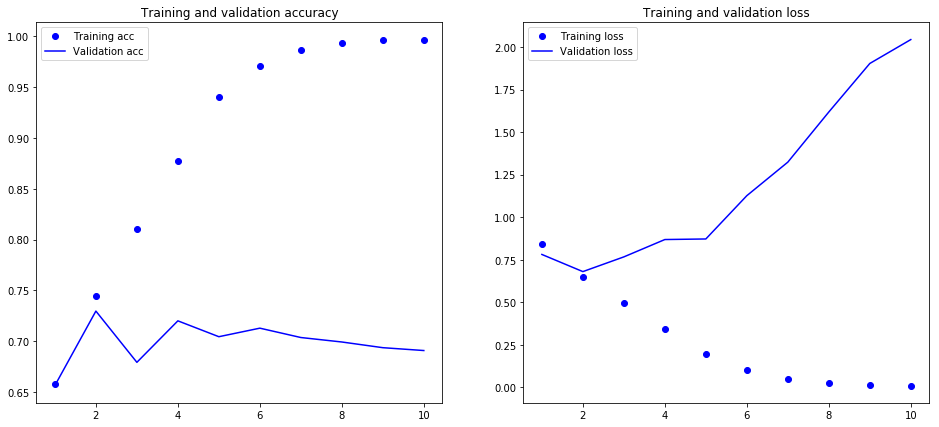

In [49]:
plot_history(h0)

# Trying stuff

In [51]:
m1 = Sequential()
m1.add(Embedding(1000, 32, input_length = 500))
m1.add(GRU(12, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
m1.add(GRU(12, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
m1.add(GRU(12, dropout = 0.2, recurrent_dropout = 0.2))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 500, 32)           32000     
_________________________________________________________________
gru_10 (GRU)                 (None, 500, 12)           1620      
_________________________________________________________________
gru_11 (GRU)                 (None, 500, 12)           900       
_________________________________________________________________
gru_12 (GRU)                 (None, 12)                900       
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 39        
Total params: 35,459
Trainable params: 35,459
Non-trainable params: 0
_________________________________________________________________


In [52]:
h1 = m1.fit(x_train, one_hot_labels, epochs = 10, batch_size = 28, verbose = 1, validation_split = 0.25)

Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 108s 14ms/step - loss: 0.8398 - acc: 0.6603 - val_loss: 0.7865 - val_acc: 0.6664
Epoch 2/10
7500/7500 [==============================] - 105s 14ms/step - loss: 0.7413 - acc: 0.7048 - val_loss: 0.7550 - val_acc: 0.6908
Epoch 3/10
7500/7500 [==============================] - 107s 14ms/step - loss: 0.7007 - acc: 0.7237 - val_loss: 0.7356 - val_acc: 0.7004
Epoch 4/10
7500/7500 [==============================] - 107s 14ms/step - loss: 0.6821 - acc: 0.7363 - val_loss: 0.7220 - val_acc: 0.7096
Epoch 5/10
7500/7500 [==============================] - 107s 14ms/step - loss: 0.6696 - acc: 0.7401 - val_loss: 0.7153 - val_acc: 0.7104
Epoch 6/10
7500/7500 [==============================] - 107s 14ms/step - loss: 0.6526 - acc: 0.7512 - val_loss: 0.7171 - val_acc: 0.7136
Epoch 7/10
7500/7500 [==============================] - 107s 14ms/step - loss: 0.6355 - acc: 0.7549 - val_loss: 0.7108 - val_acc: 

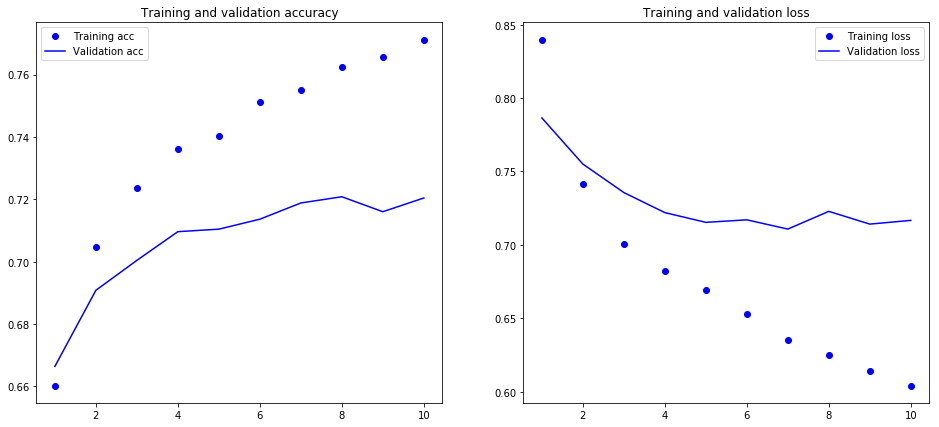

In [53]:
plot_history(h1)

# Testing stufferinos #2

dataset 50 000 reviews, runtime LONG, doesn't overfit, validadtion accuracy 78,6% and loss 0,572 this run.

In [65]:
m2 = Sequential()
m2.add(Embedding(1000, 32, input_length = 500))
m2.add(GRU(12, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
m2.add(GRU(12, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
m2.add(GRU(12, dropout = 0.2, recurrent_dropout = 0.2))
m2.add(Dense(3, activation = 'softmax'))
m2.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 500, 32)           32000     
_________________________________________________________________
gru_18 (GRU)                 (None, 500, 12)           1620      
_________________________________________________________________
gru_19 (GRU)                 (None, 500, 12)           900       
_________________________________________________________________
gru_20 (GRU)                 (None, 12)                900       
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 39        
Total params: 35,459
Trainable params: 35,459
Non-trainable params: 0
_________________________________________________________________


In [66]:
h2 = m2.fit(x_train, one_hot_labels, epochs = 10, batch_size = 22, verbose = 1, validation_split = 0.25)

Train on 37500 samples, validate on 12500 samples
Epoch 1/10
37500/37500 [==============================] - 697s 19ms/step - loss: 0.7512 - acc: 0.7016 - val_loss: 0.6956 - val_acc: 0.7275
Epoch 2/10
37500/37500 [==============================] - 675s 18ms/step - loss: 0.6779 - acc: 0.7397 - val_loss: 0.6608 - val_acc: 0.7453
Epoch 3/10
37500/37500 [==============================] - 674s 18ms/step - loss: 0.6467 - acc: 0.7554 - val_loss: 0.6274 - val_acc: 0.7599
Epoch 4/10
37500/37500 [==============================] - 680s 18ms/step - loss: 0.6253 - acc: 0.7674 - val_loss: 0.6102 - val_acc: 0.7678
Epoch 5/10
37500/37500 [==============================] - 692s 18ms/step - loss: 0.6121 - acc: 0.7731 - val_loss: 0.6087 - val_acc: 0.7730
Epoch 6/10
37500/37500 [==============================] - 691s 18ms/step - loss: 0.5980 - acc: 0.7813 - val_loss: 0.5941 - val_acc: 0.7750
Epoch 7/10
37500/37500 [==============================] - 705s 19ms/step - loss: 0.5862 - acc: 0.7844 - val_loss: 0.

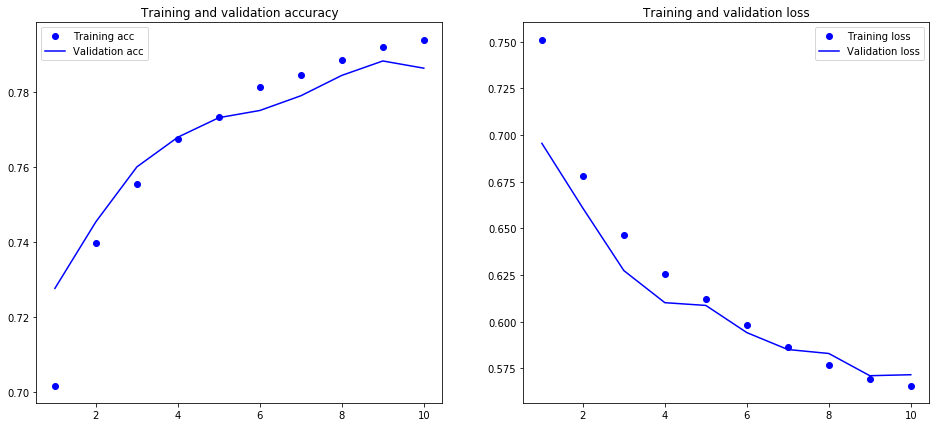

In [67]:
plot_history(h2)

Koitin tallentaa sekä modelin että sen weightit varmuuden vuoksi ettei sitä tarvitse uusiksi ajaa, validoitu tässä kohtaa nyt training + validation datan kokonaisuudella eli kaikilla 50 000 arvolla. Teoriassa voisi myös ajaa test datasetillä.

In [69]:
from keras.models import load_model
m2.save('case_3_8.h5')

In [82]:
# Save the weights
m2.save_weights('case3_weights')

# Restore the weights
m3 = Sequential()
m3.add(Embedding(1000, 32, input_length = 500))
m3.add(GRU(12, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
m3.add(GRU(12, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
m3.add(GRU(12, dropout = 0.2, recurrent_dropout = 0.2))
m3.add(Dense(3, activation = 'softmax'))
m3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m3.load_weights('case3_weights')

loss,acc = m3.evaluate(x_train, one_hot_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

50000/50000 [==============================] - 105s 2ms/step
Restored model, accuracy: 80.08%


In [88]:
# Pickle allows for saving all the accuracies and losses both for validation and training data after every epoch
# so we can make graph without running whole thing again

import pickle
with open('valuesForGraphs', 'wb') as f:
    pickle.dump(h2.history, f)

In [89]:
h4 = pickle.load( open( "valuesForGraphs", "rb" ) )
h4

{'val_loss': [0.6955774086761475,
  0.6608470801496505,
  0.6273753600025177,
  0.610180664832592,
  0.6087041994929314,
  0.5941403232336044,
  0.5850761218881607,
  0.582947294242382,
  0.5710386028003692,
  0.5715621879124642],
 'val_acc': [0.7275199988031388,
  0.7452800000667572,
  0.7599199997711181,
  0.7678400000858306,
  0.773040000424385,
  0.774960000743866,
  0.7788800004673004,
  0.7843200004196167,
  0.7881600007438659,
  0.7862400013160705],
 'loss': [0.7512035208590825,
  0.6779229148117701,
  0.6466745213135083,
  0.6252887561996778,
  0.6120953818233807,
  0.5980305860582987,
  0.5862437050477664,
  0.5770344327775637,
  0.569387019349734,
  0.5657873747968674],
 'acc': [0.7016266660992304,
  0.7396533328310648,
  0.7553866665363311,
  0.7673866674804688,
  0.7731200004053116,
  0.7813066676870982,
  0.7844266673008601,
  0.7884000005499522,
  0.7918933342885971,
  0.79386666812102]}

{'val_loss': [0.6955774086761475,
  0.6608470801496505,
  0.6273753600025177,
  0.610180664832592,
  0.6087041994929314,
  0.5941403232336044,
  0.5850761218881607,
  0.582947294242382,
  0.5710386028003692,
  0.5715621879124642],
 'val_acc': [0.7275199988031388,
  0.7452800000667572,
  0.7599199997711181,
  0.7678400000858306,
  0.773040000424385,
  0.774960000743866,
  0.7788800004673004,
  0.7843200004196167,
  0.7881600007438659,
  0.7862400013160705],
 'loss': [0.7512035208590825,
  0.6779229148117701,
  0.6466745213135083,
  0.6252887561996778,
  0.6120953818233807,
  0.5980305860582987,
  0.5862437050477664,
  0.5770344327775637,
  0.569387019349734,
  0.5657873747968674],
 'acc': [0.7016266660992304,
  0.7396533328310648,
  0.7553866665363311,
  0.7673866674804688,
  0.7731200004053116,
  0.7813066676870982,
  0.7844266673008601,
  0.7884000005499522,
  0.7918933342885971,
  0.79386666812102]}

In [36]:
m6 = Sequential()
m6.add(Embedding(1000, 32, input_length = 500))
m6.add(Conv1D(32, 5, activation = 'relu'))
m6.add(MaxPooling1D(5))
m6.add(Conv1D(32, 7, activation = 'relu'))
m6.add(GRU(8, dropout = 0.1, recurrent_dropout = 0.5))
m6.add(Dense(3, activation = 'softmax'))
m6.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           32000     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 496, 32)           5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 99, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 93, 32)            7200      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 984       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 27        
Total params: 45,363
Trainable params: 45,363
Non-trainable params: 0
_________________________________________________________________


Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 15s 2ms/step - loss: 0.8248 - acc: 0.6625 - val_loss: 0.7396 - val_acc: 0.6976
Epoch 2/10
7500/7500 [==============================] - 14s 2ms/step - loss: 0.6816 - acc: 0.7364 - val_loss: 0.7100 - val_acc: 0.7168
Epoch 3/10
7500/7500 [==============================] - 13s 2ms/step - loss: 0.6307 - acc: 0.7616 - val_loss: 0.6871 - val_acc: 0.7244
Epoch 4/10
7500/7500 [==============================] - 14s 2ms/step - loss: 0.5957 - acc: 0.7803 - val_loss: 0.6902 - val_acc: 0.7264
Epoch 5/10
7500/7500 [==============================] - 14s 2ms/step - loss: 0.5577 - acc: 0.7936 - val_loss: 0.7760 - val_acc: 0.7108
Epoch 6/10
7500/7500 [==============================] - 14s 2ms/step - loss: 0.5087 - acc: 0.8171 - val_loss: 0.7078 - val_acc: 0.7256
Epoch 7/10
7500/7500 [==============================] - 14s 2ms/step - loss: 0.4453 - acc: 0.8407 - val_loss: 0.7851 - val_acc: 0.7292
Epoch 8

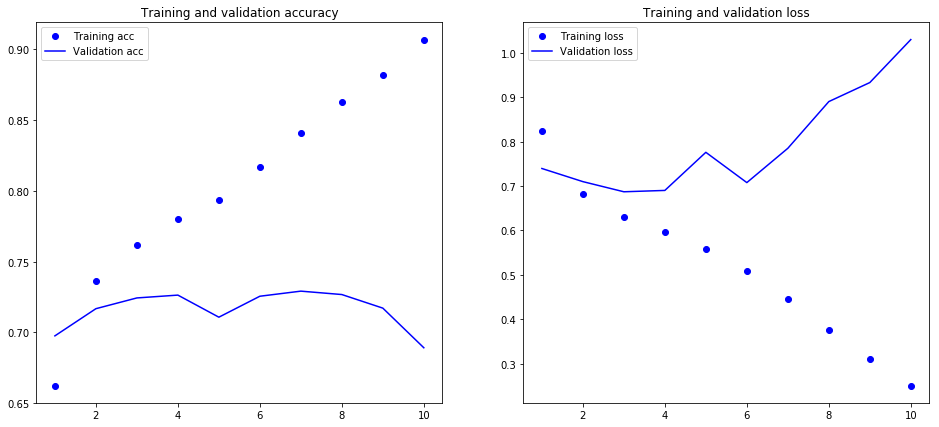

In [38]:
h6 = m6.fit(x_train, one_hot_labels, epochs = 10, batch_size = 32, verbose = 1, validation_split = 0.25)
plot_history(h6)